# Introduction

In this analysis, we aim to cluster our dataset based on the one-hot encoded categorical features and visualize the top categories within each cluster. We use Principal Component Analysis (PCA) to reduce the dimensionality of the data for visualization and K-means clustering to group similar data points together. We then use various different charts to visualize the results.

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
import seaborn as sns

In [77]:
cat_df = pd.read_csv("categories_cleaned.csv")

# Clustering
We use K-means clustering to group similar data points. The optimal number of clusters is determined using the elbow method, where we plot the inertia for different numbers of clusters and look for an "elbow" point.

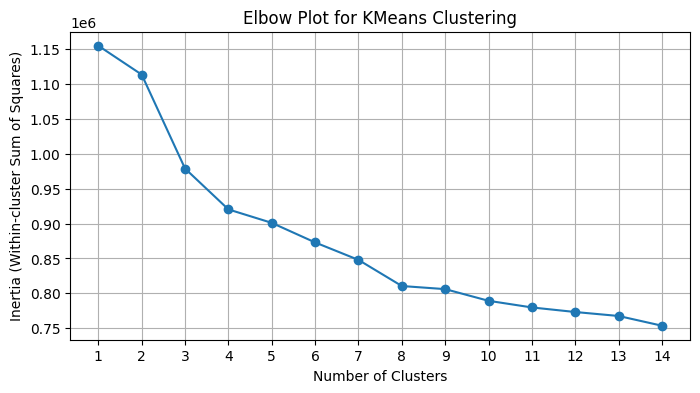

In [78]:
range_n_clusters = list(range(1, 15))
inertia_values = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(cat_df.iloc[:, 2:].values )
    inertia_values.append(kmeans.inertia_)

# Plot the elbow plot
plt.figure(figsize=(8, 4))
plt.plot(range_n_clusters, inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.title('Elbow Plot for KMeans Clustering')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

### Choosing K-Value

In the analysis of this elbow plot there are two viable K-values to use: 8 & 10. For the purpose of our analysis, 10 was chosen as to limit the clusters' size to better handle the cosine similarity matrix in the content-filtering model.

In [79]:
def k_means(df: pd.DataFrame):
    X = cat_df.iloc[:, 2:].values 
    kmeans = KMeans(n_clusters=10, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    df['Cluster'] = labels


In [94]:
k_means(cat_df)
cat_df[['shiur','Cluster']].head()

,shiur,Cluster
0,1100127,1
1,1100126,1
2,1100125,0
3,1100124,5
4,1100123,5


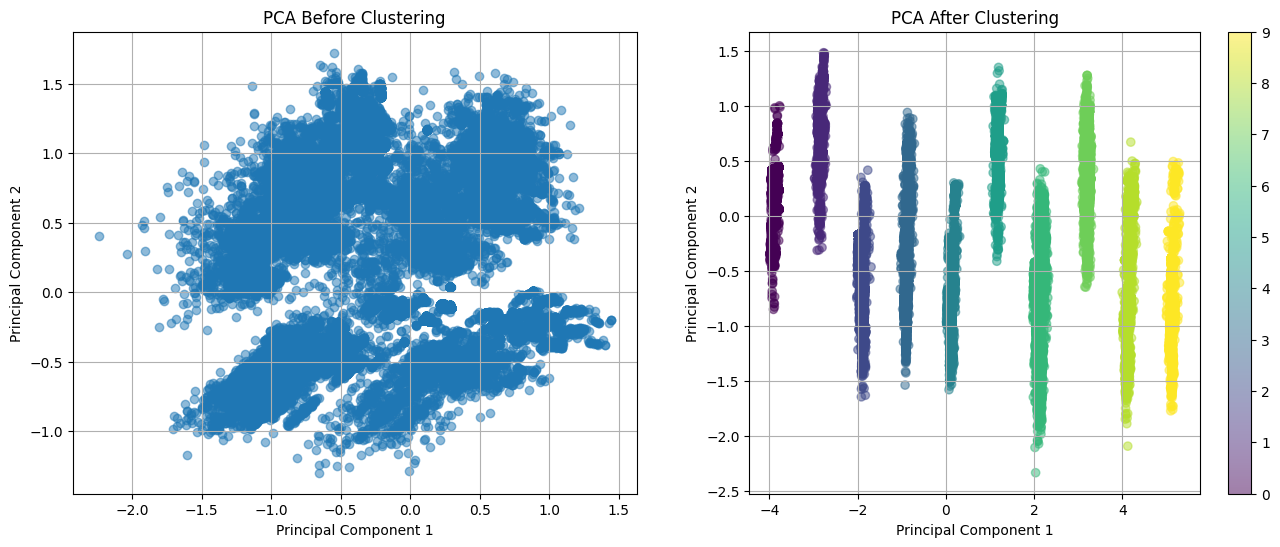

In [81]:
def plot_pca(cluster=True):
    X = cat_df.iloc[:, 2:].values if cluster else cat_df.iloc[:, 2:-1].values

    # Apply PCA to reduce to 2 dimensions
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Create a new DataFrame with the PCA results
    pca_df = pd.DataFrame(data=X_pca, columns=['Principal Component 1', 'Principal Component 2'])
    if cluster:
        pca_df['Cluster'] = cat_df['Cluster']
    
    return pca_df

# Prepare data for both scenarios
pca_df_before = plot_pca(cluster=False)
pca_df_after = plot_pca(cluster=True)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot PCA before clustering
ax[0].scatter(pca_df_before['Principal Component 1'], pca_df_before['Principal Component 2'], alpha=0.5)
ax[0].set_title('PCA Before Clustering')
ax[0].set_xlabel('Principal Component 1')
ax[0].set_ylabel('Principal Component 2')
ax[0].grid(True)

# Plot PCA after clustering
scatter = ax[1].scatter(pca_df_after['Principal Component 1'], pca_df_after['Principal Component 2'], c=pca_df_after['Cluster'], cmap='viridis', alpha=0.5)
fig.colorbar(scatter, ax=ax[1])
ax[1].set_title('PCA After Clustering')
ax[1].set_xlabel('Principal Component 1')
ax[1].set_ylabel('Principal Component 2')
ax[1].grid(True)

plt.show()


## Merge Shiur Data & Save 

In [82]:
shiur_df = pd.read_csv("shiurim_cleaned.csv")
df = shiur_df.merge(
         cat_df[['shiur', 'Cluster']], on='shiur', how='left')

In [83]:
for i in range(10):
    # Filter the DataFrame for the current cluster
    cluster_df = df[df['Cluster'] == i].sort_values("shiur", ascending=False)
    
    # Save the cluster DataFrame to a CSV file
    cluster_df.to_csv(f"clusters/cluster{i}.csv", index=False)

### Summary Stats for all Clusters

In [84]:
summary_df = pd.DataFrame()
for i in range(10):
    # Filter the DataFrame for the current cluster
    cluster_df = df[df['Cluster'] == i].sort_values("shiur", ascending=False)
    categories = cluster_df['category'].value_counts()
    summary_df[f"Cluster {i}"] = categories
 
summary_df['Totals'] = shiur_df['category'].value_counts()
sums = summary_df.sum(axis=0)

# Add the sums as a new row
summary_df.loc['Totals'] = sums
summary_df.to_csv("clusters/summary.csv")


#### By comparing the sum of the summary stats to the shape, this ensures that each shiur is placed into a cluster

In [85]:
(sums.sum() - sums['Totals']) == shiur_df.shape[0]

True

In [86]:
summary_df

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Totals
category,,,,,,,,,,,
Mishna,15162,387,307,251,69,75,226,193,47,19,16736
Holidays,3801,11,957,397,153,22,319,62,79,137,5938
Personalities,1839,11,463,104,231,5,176,15,51,29,2924
History,1249,6,247,98,24,8,115,11,9,133,1900
Yerushalmi,1236,97,8,29,4,122,2,183,1,14,1696
Halacha,138,370,2183,55918,1072,247,716,1138,864,94,62740
Machshava,118,114,38564,770,2868,56,7727,243,535,502,51497
Midrash,58,2,20,2,79,1,16,1,13,10,202
Gemara,53,23827,200,3196,219,39842,374,37693,284,79,105767


#### Above code is put into methods to be used for category, middle_category, and subcategory

In [87]:
def get_stats(column_name='category'):
    summary_df = pd.DataFrame()
    
    for i in range(10):
        # Filter the DataFrame for the current cluster
        cluster_df = df[df['Cluster'] == i].sort_values("shiur", ascending=False)
        categories = cluster_df[column_name].value_counts().to_frame(f"Cluster {i}")
        summary_df = pd.concat([summary_df, categories], axis=1)
    
    summary_df['Totals'] = df[column_name].value_counts()
    summary_df = summary_df.fillna(0)
    
    # Sum of the rows to include in 'Totals'
    sums = summary_df.sum(axis=0)
    summary_df.loc['Totals'] = sums
    
    summary_df.to_csv(f"clusters/summary_{column_name}.csv")
    return summary_df


In [88]:
def plot_stats_heatmap(column_name = 'category'):
    # Load the summary DataFrame (assuming you already have it saved as "clusters/summary.csv")
    summary_df = pd.read_csv(f"clusters/summary_{column_name}.csv", index_col=0)

    # Drop the 'Total' column and 'Sum' row for the heatmap
    heatmap_data = summary_df.drop(columns=['Totals']).drop(index=['Totals'])

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, fmt="g", cmap="viridis", cbar_kws={'label': 'Count'})
    plt.title("Category Counts by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Category")
    plt.show()


In [89]:
def plot_stats_bar(column_name='category'):
    # Load the summary DataFrame
    summary_df = pd.read_csv(f"clusters/summary_{column_name}.csv", index_col=0)

    # Drop the 'Total' column and 'Sum' row
    heatmap_data = summary_df.drop(columns=['Totals']).drop(index=['Totals'])

    # Calculate maximum count for consistent y-axis limits
    max_count = heatmap_data.max().max()

    # Create bar plots for each cluster
    num_clusters = 10
    num_rows = (num_clusters + 2) // 3  # Calculate the number of rows needed for 3 plots per row
    fig, axes = plt.subplots(num_rows, 3, figsize=(20, num_rows * 6), sharex=True)

    for i in range(num_clusters):
        row = i // 3
        col = i % 3
        cluster_data = heatmap_data[f'Cluster {i}'].sort_values(ascending=False).head(10)

        # Plot the data if the cluster is not empty
        if not cluster_data.empty:
            sns.barplot(x=cluster_data.values, y=cluster_data.index, ax=axes[row, col])
            axes[row, col].set_title(f'Cluster {i} Top 10 {column_name} Counts')
            axes[row, col].set_xlabel('Count')
            axes[row, col].set_ylabel(column_name)
            axes[row, col].set_xlim(0, max_count)  # Set consistent x-axis limits

            # Add value labels
            for j in range(len(cluster_data)):
                axes[row, col].text(cluster_data.values[j], j, f'{cluster_data.values[j]}', color='black', ha="left", va="center")

    # Hide any unused subplots
    for j in range(num_clusters, num_rows * 3):
        fig.delaxes(axes[j // 3, j % 3])

    plt.tight_layout()
    plt.show()


In [90]:
cat_stats = get_stats('category')
middle_cat_stats = get_stats('middle_category')
sub_cat_stats = get_stats('subcategory')


## Visualization

Through heatmaps and bar charts we can see the cluster distribution.

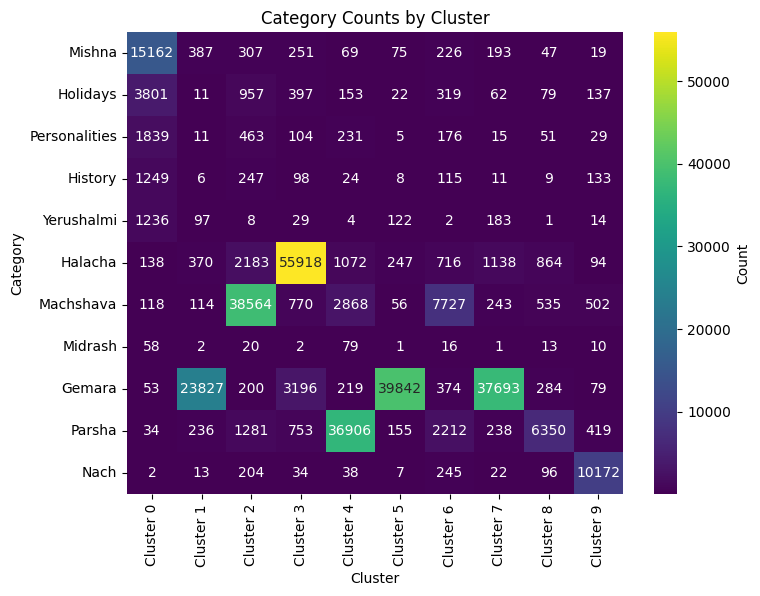

In [91]:
plot_stats_heatmap('category')

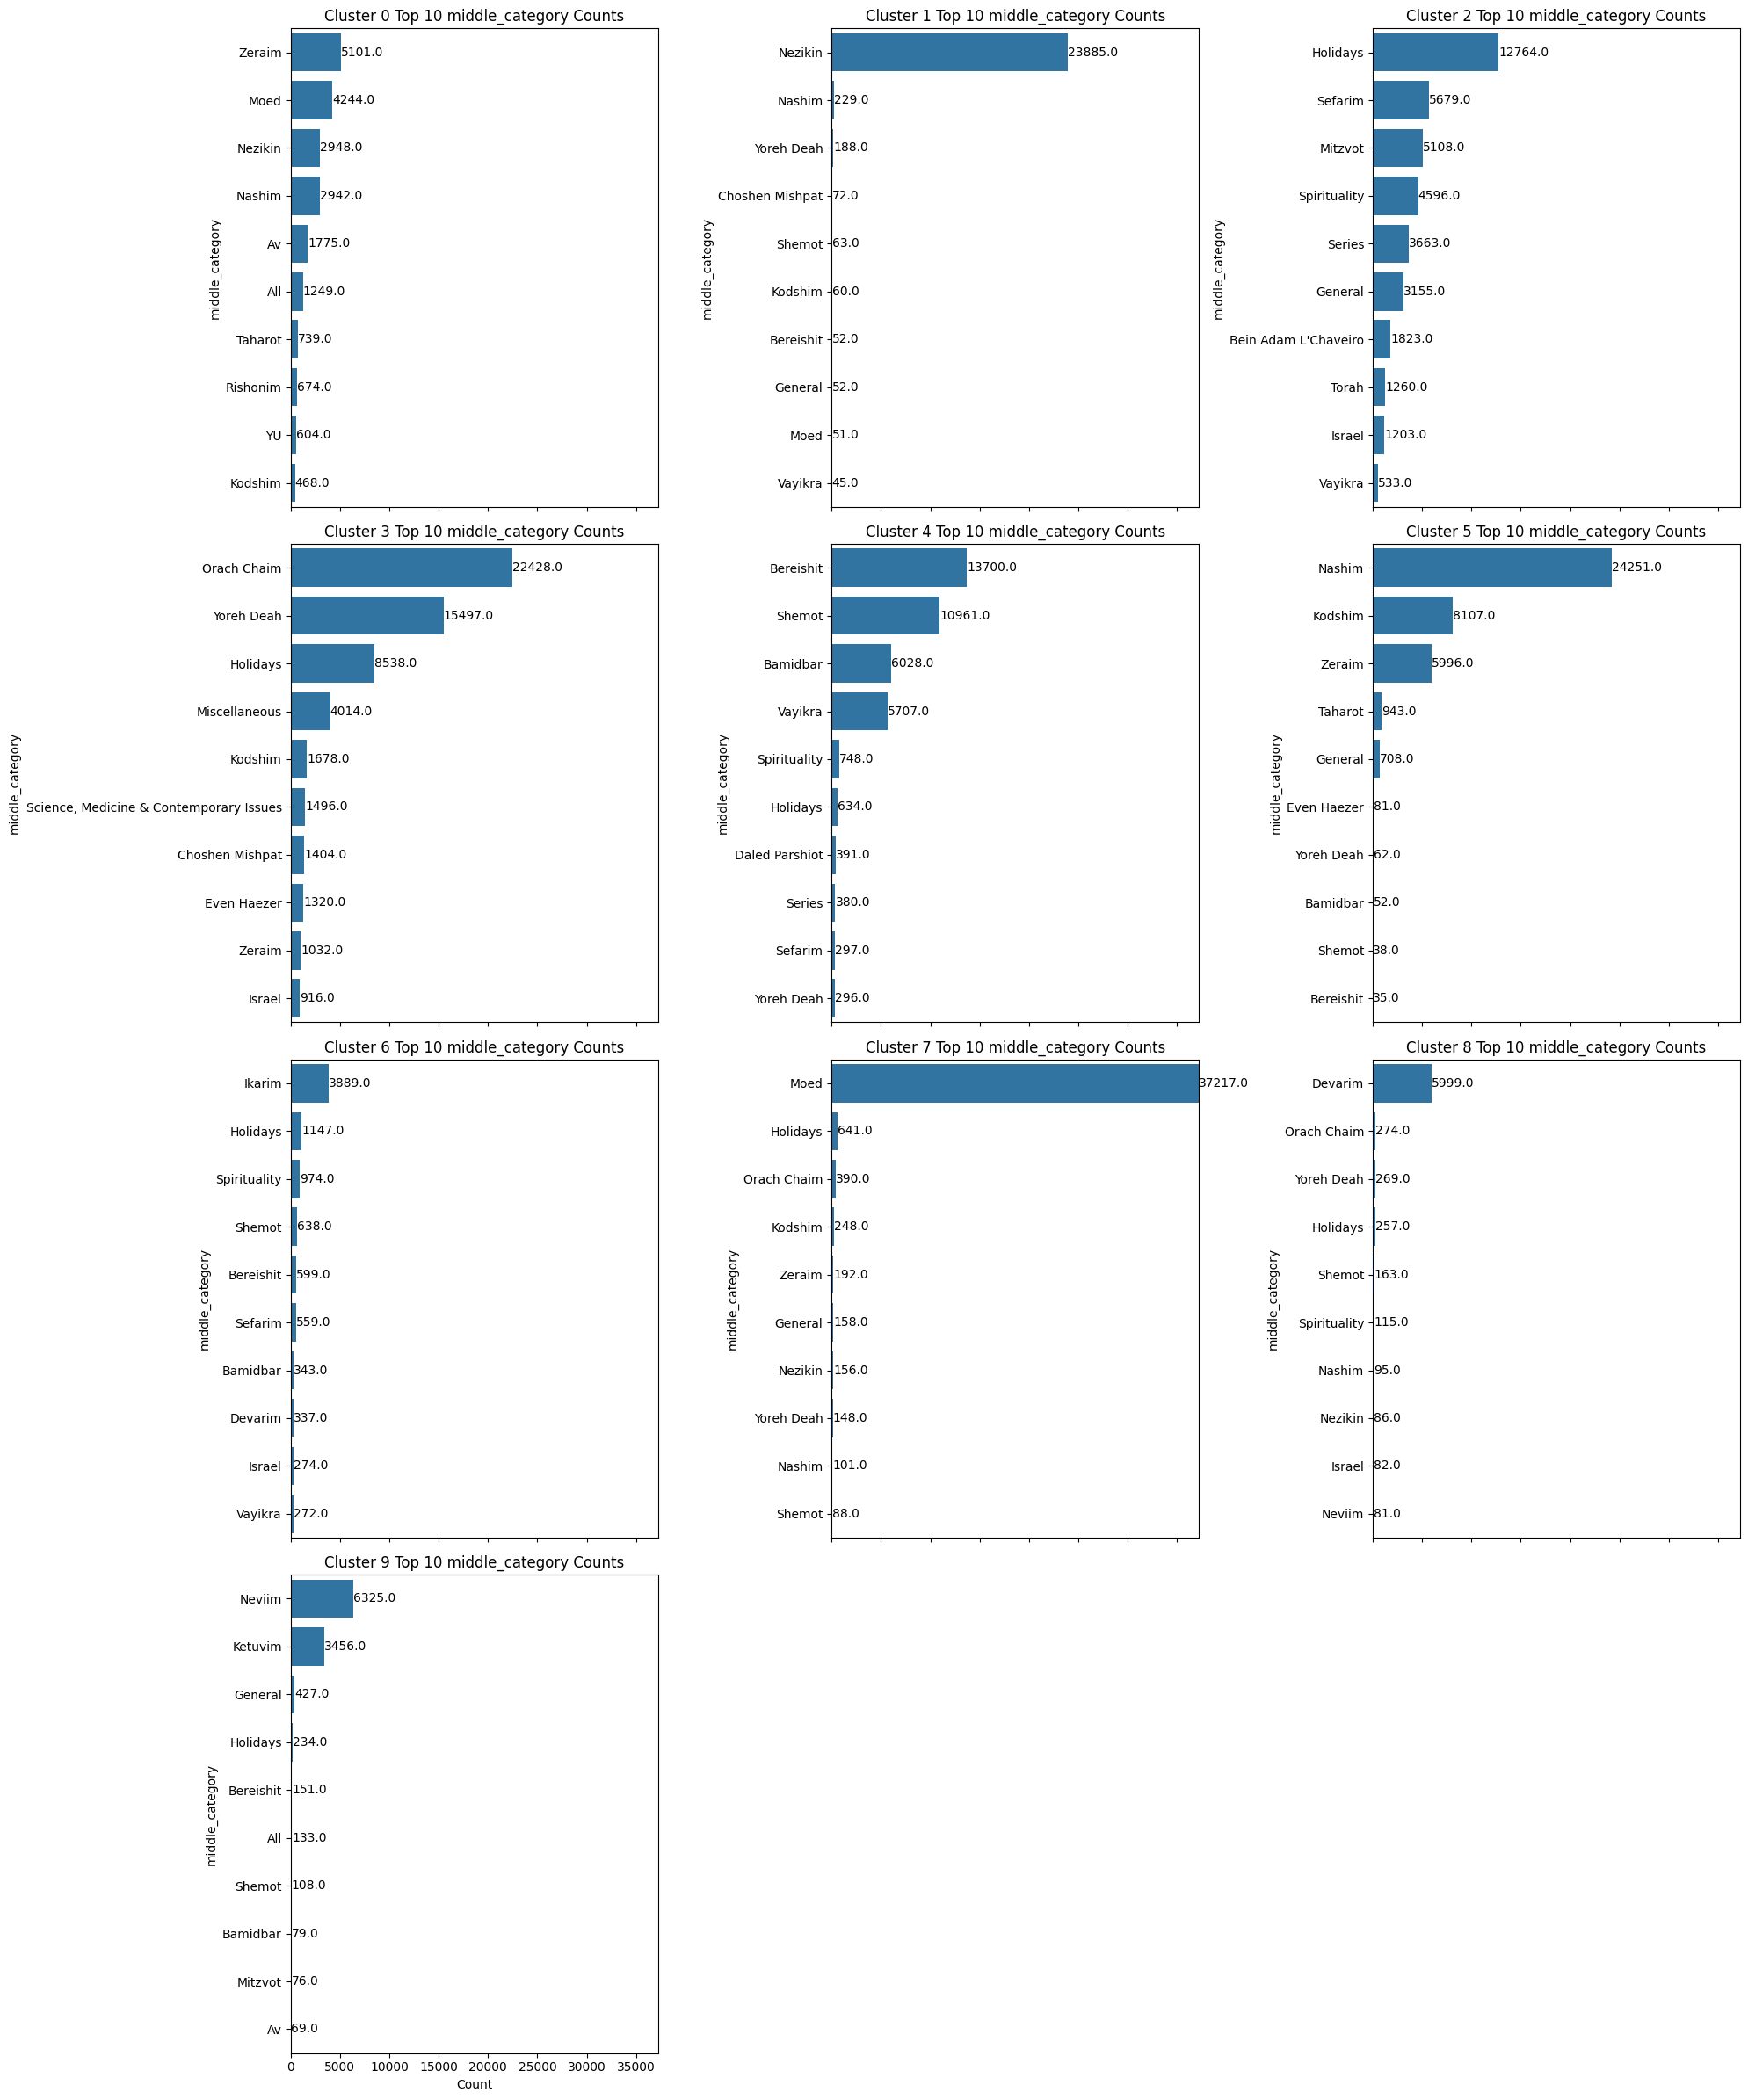

In [92]:
plot_stats_bar('middle_category')

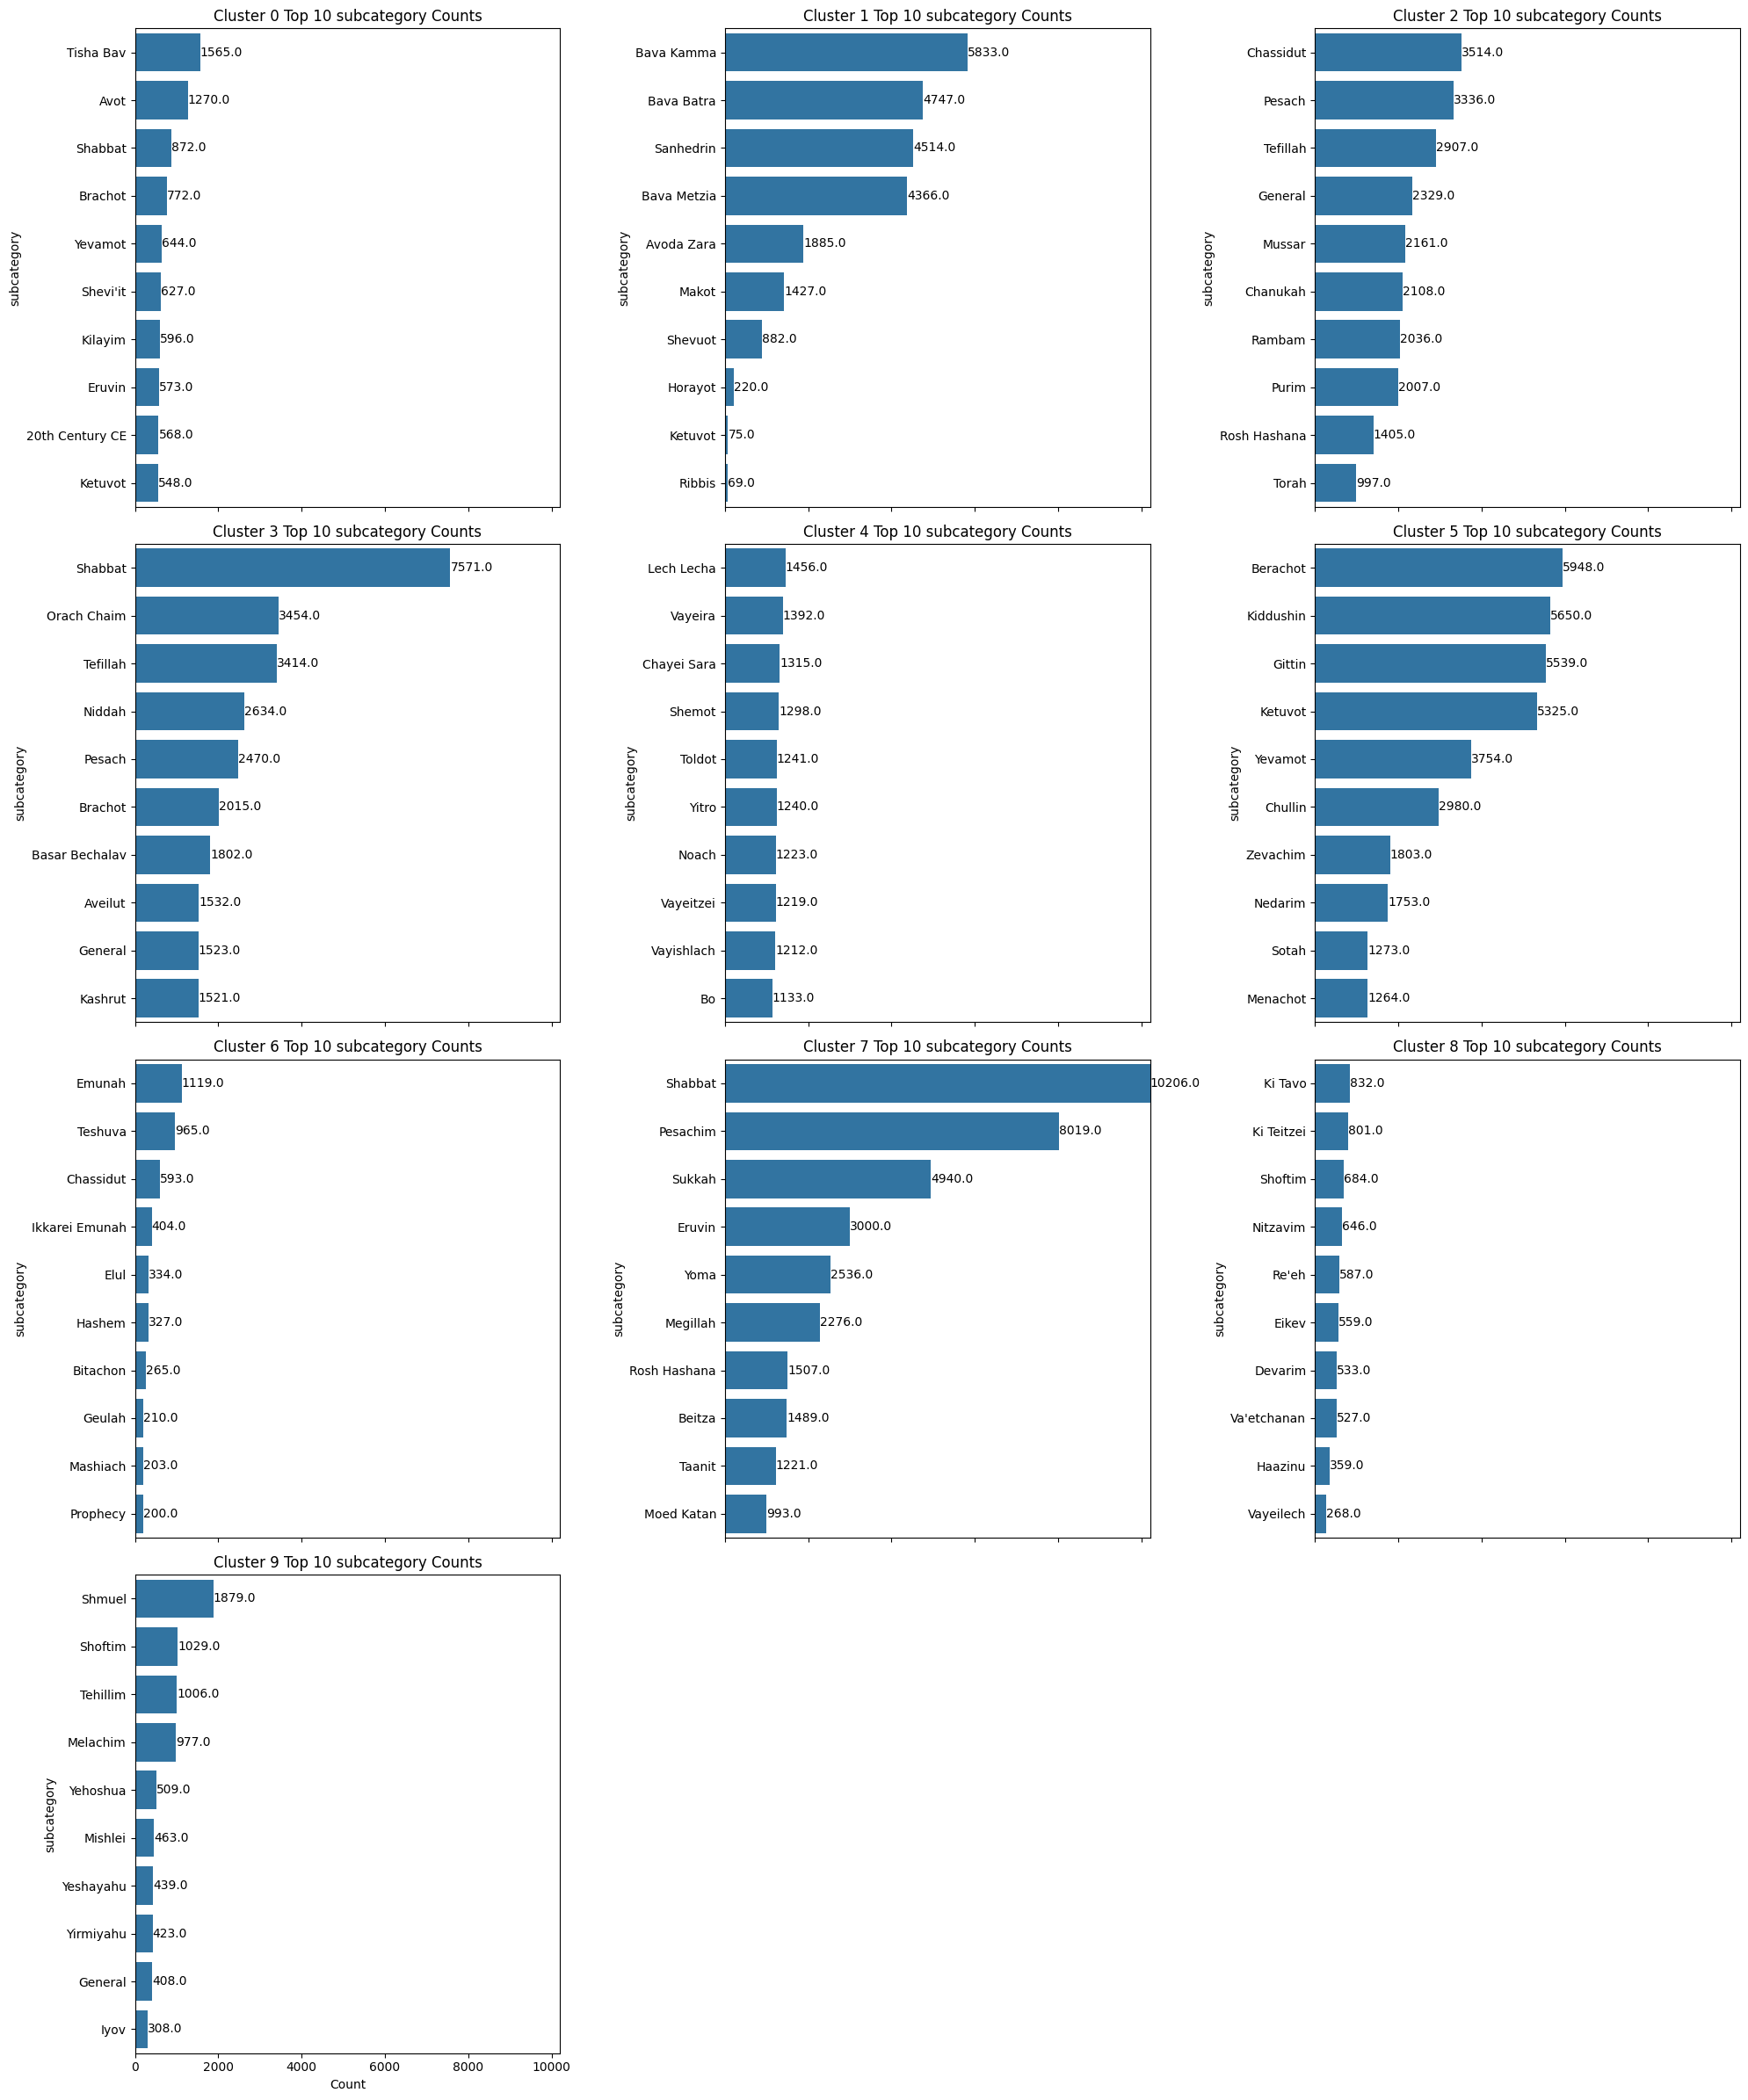

In [93]:
plot_stats_bar('subcategory')

## Conclusion

In this notebook, we have successfully clustered our dataset and visualized the distribution of top categories within each cluster. The PCA plots provide an intuitive understanding of the data before and after clustering, and the bar plots help in identifying the prominent categories within each cluster. These clusters are then processed through Word2Vec and cosine similarity computations to make the content filtering model more managable for our large dataset.